In [ ]:
!pip install transformers==4.18.0
!pip install sentencepiece
!pip install datasets
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 16.2 MB/s 
     |████████████████████████████████| 880 kB 54.4 MB/s 
     |████████████████████████████████| 163 kB 66.4 MB/s 
     |████████████████████████████████| 6.6 MB 56.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=ae7c32d1d63f1c214ed65c5191657bfd9a87b5b6dbefe0b569dea408e2236924
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 19.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 43.6 MB/s 
     |████████████████████████████████| 95 kB 3.9 MB/s 
  

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

import tensorflow as tf
from datasets import Dataset, DatasetDict
from transformers import T5Tokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
from rouge_score import rouge_scorer

#importing the data from google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/PBL Final/test.csv')

In [ ]:
checkpoint="t5-base"
tokenizer = T5Tokenizer.from_pretrained(checkpoint)
model= TFAutoModelForSeq2SeqLM.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11490 entries, 0 to 11489
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11490 non-null  object
 1   article     11490 non-null  object
 2   highlights  11490 non-null  object
dtypes: object(3)
memory usage: 269.4+ KB


In [ ]:
print("Number of rows in the data:",data.shape[0])

Number of rows in the data: 11490


In [ ]:
#checking the data for missing values
data.isna().sum()

id            0
article       0
highlights    0
dtype: int64

In [ ]:
#function to remove numbers and punctuations in the data
#removing numbers and punctuations to get exact number of words in the data
def clean_text(text):
  text = text.lower()
  text = re.sub(pattern=r"[^a-zA-Z0-9_\s]",repl="",string=text)
  text = re.sub(pattern=r" {2,10}",repl=" ",string=text)
  return text

In [ ]:
cleaned_data=pd.DataFrame()
cleaned_data['article'] = data['article'].apply(clean_text)
cleaned_data['highlights'] = data['highlights'].apply(clean_text)

summary_lengths=[len(summary.split()) for summary in cleaned_data['highlights']]
text_lengths=[len(text.split()) for text in cleaned_data['article']]

Text(0.5, 0.98, 'Distribution of words in summary and original text')

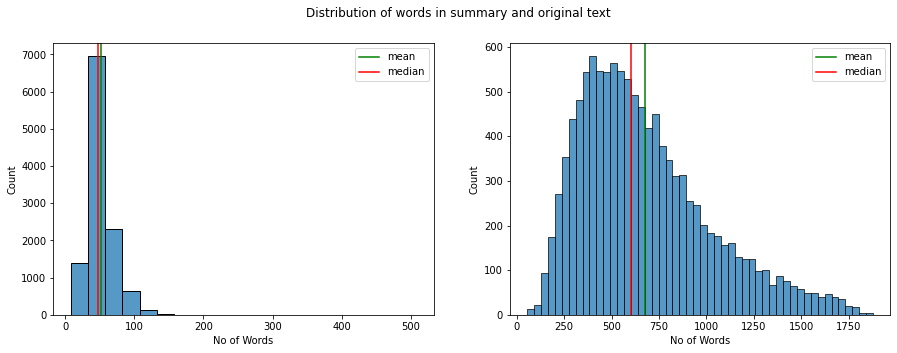

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(summary_lengths,bins=20)
plt.axvline(np.mean(summary_lengths),color="g",label="mean")
plt.axvline(np.median(summary_lengths),color="r",label="median")
plt.legend()
plt.xlabel("No of Words")
plt.subplot(1,2,2)
sns.histplot(text_lengths,bins=50)
plt.axvline(np.mean(text_lengths),color="g",label="mean")
plt.axvline(np.median(text_lengths),color="r",label="median")
plt.legend()
plt.xlabel("No of Words")
plt.suptitle("Distribution of words in summary and original text")

In [ ]:
print("Average number of words in the summary are:",np.median(summary_lengths))
print("Average number of words in the complete text are:",np.median(text_lengths))

Average number of words in the summary are: 48.0
Average number of words in the complete text are: 605.0


In [ ]:
#adding summarize: as prefix for the input sequence
#because the T5 model has been pretrained in the similar fashion for summarization tasks
data['article']=data['article'].apply(lambda x:"summarize: "+x)
data.head(5)

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,summarize: Ever noticed how plane seats appear...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,summarize: A drunk teenage boy had to be rescu...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,summarize: Dougie Freedman is on the verge of ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,summarize: Liverpool target Neto is also wante...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,summarize: Bruce Jenner will break his silence...,"Tell-all interview with the reality TV star, 6..."


In [ ]:
#splitting the data into train and validation split in the ratio (85:15)
split = int(len(data)/100*85)
training_data = data[:split]
valid_data = data[split:]

#saving the training and validation split into CSV
training_data.to_csv("news_summarization_training.csv")
valid_data.to_csv("news_summarization_validation.csv")

In [ ]:
#importing the dataset into huggingface dataset format for efficient handling and training
train_data = pd.read_csv("news_summarization_training.csv",index_col=None)
valid_data = pd.read_csv("news_summarization_validation.csv",index_col=None)
train = Dataset.from_pandas(train_data[0:200])
valid = Dataset.from_pandas(valid_data[0:50])
dataset=DatasetDict()
dataset['training']=train.remove_columns(['Unnamed: 0'])
dataset['validation']=valid.remove_columns(['Unnamed: 0'])
dataset

DatasetDict({
    training: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 50
    })
})

In [ ]:
train.shape

(200, 4)

In [ ]:
valid.shape

(50, 4)

In [ ]:
max_input_length=512
max_target_length=80
def preprocess(example):
  input = tokenizer(example['article'],
                    max_length=max_input_length,
                    truncation=True,
                    )
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(example['highlights'],
                       max_length=max_target_length,
                       truncation=True)
  input['labels']=labels['input_ids']
  return input

In [ ]:
tokenized_dataset = dataset.map(preprocess,batched=True)
tokenized_dataset

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    training: Dataset({
        features: ['id', 'article', 'highlights', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['id', 'article', 'highlights', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 50
    })
})

In [ ]:
tokenized_dataset.remove_columns(['highlights','article'])

DatasetDict({
    training: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 50
    })
})

In [ ]:
datacollator=DataCollatorForSeq2Seq(tokenizer,model=model,return_tensors="tf")

In [ ]:

tf_train_dataset = tokenized_dataset['training'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=datacollator,
    shuffle=True,
    batch_size=1
)
tf_train_dataset

<PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [ ]:
tf_valid_dataset = tokenized_dataset['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=datacollator,
    shuffle=False,
    batch_size=1)
tf_valid_dataset

<PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [ ]:
epochs = 10
#No of training steps are len(dataset)/batch_size*no of epochs
num_train_steps = len(tf_train_dataset) * epochs

#creating a optimizer using transformers create optimizer
optimizer, schedule = create_optimizer(
    init_lr=4e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer) #for loss the model will use the models internal loss by default

# Training in mixed-precision float16 for faster training and efficient memory usage
tf.keras.mixed_precision.set_global_policy("mixed_float16")

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
history = model.fit(tf_train_dataset,validation_data=tf_valid_dataset,epochs=epochs)

Epoch 1/10
200/200 [==============================] - 102s 317ms/step - loss: 1.7606 - val_loss: 1.4666
Epoch 2/10
200/200 [==============================] - 55s 275ms/step - loss: 1.4521 - val_loss: 1.4717
Epoch 3/10
200/200 [==============================] - 56s 282ms/step - loss: 1.2721 - val_loss: 1.4914
Epoch 4/10
200/200 [==============================] - 58s 288ms/step - loss: 1.1255 - val_loss: 1.5103
Epoch 5/10
200/200 [==============================] - 57s 287ms/step - loss: 1.0087 - val_loss: 1.5343
Epoch 6/10
200/200 [==============================] - 56s 282ms/step - loss: 0.9150 - val_loss: 1.5687
Epoch 7/10
200/200 [==============================] - 56s 282ms/step - loss: 0.8404 - val_loss: 1.5860
Epoch 8/10
200/200 [==============================] - 57s 283ms/step - loss: 0.7899 - val_loss: 1.6041
Epoch 9/10
200/200 [==============================] - 56s 279ms/step - loss: 0.7532 - val_loss: 1.6157
Epoch 10/10
200/200 [==============================] - 56s 279ms/step - 

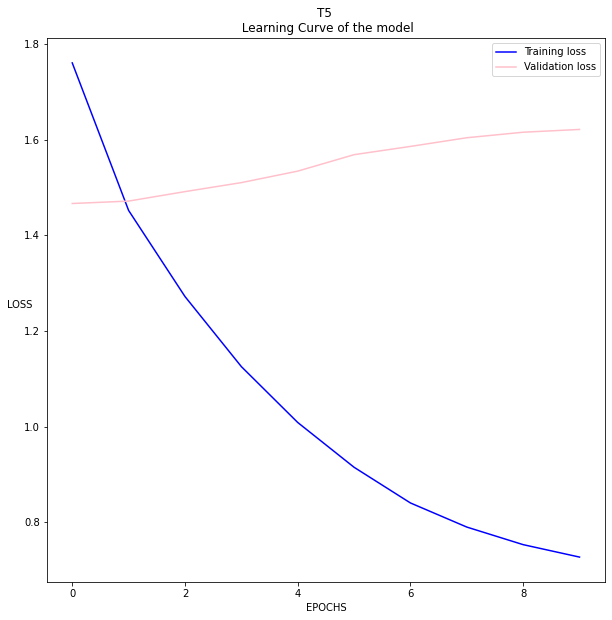

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'],color="blue", label="Training loss")
plt.plot(history.history['val_loss'],color="pink", label="Validation loss")
plt.xlabel("EPOCHS")
plt.ylabel("LOSS",rotation=0)
plt.title("T5 \n Learning Curve of the model")
plt.legend()

In [ ]:
#generating the summaries on the testing dataset
#testing only on the first 100 samples
reference=[]
model_generated=[]
for i,batch in enumerate(tqdm(tf_valid_dataset),start=1):
  if i>101:
    break
  labels=batch['labels'].numpy()
  labels=np.where(labels!=-100,labels,tokenizer.pad_token_id)
  labels=tokenizer.batch_decode(labels,skip_special_tokens=True)
  reference.extend(labels)
  pred=model.generate(**batch,min_length=55,max_length=100)
  pred_decoded = tokenizer.batch_decode(pred,skip_special_tokens=True)
  model_generated.extend(pred_decoded)

100%|██████████| 50/50 [11:17<00:00, 13.56s/it]


In [ ]:
def calc_metrics(preds,actual):
  metrics=['rouge1','rouge2','rougeL']
  result={metrics[0]:[],metrics[1]:[],metrics[2]:[]}
  for metric in metrics:
    precision=[]
    recall=[]
    f1=[]
    scorer = rouge_scorer.RougeScorer([metric],use_stemmer=True)
    for x,y in zip(model_generated,reference):
      scores = scorer.score(x,y)
      precision.append(scores[metric][0])
      recall.append(scores[metric][1])
      f1.append(scores[metric][2])
    result[metric].append(np.mean(precision))
    result[metric].append(np.mean(recall))
    result[metric].append(np.mean(f1))
  return pd.DataFrame(result,index=['Precision','Recall','F1-Score'])

In [ ]:
scores=calc_metrics(model_generated,reference)
scores

,rouge1,rouge2,rougeL
Precision,0.480067,0.242924,0.354816
Recall,0.454104,0.228289,0.337644
F1-Score,0.462100,0.232719,0.342563


In [ ]:
!pip install evaluate
import evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.6 MB/s 


In [ ]:
rouge_score = evaluate.load("rouge")

In [ ]:
result = rouge_score.compute(
    predictions=pred_decoded, references=labels, use_stemmer=True
)
result

{'rouge1': 0.5178571428571429,
 'rouge2': 0.2909090909090909,
 'rougeL': 0.3928571428571429,
 'rougeLsum': 0.3928571428571429}